# XGBoost
- e**X**tra **G**radient **Boost**
- GBM 기반이지만 느린 수행 시간과 과적합 규제 등의 문제 해결
    - 병렬 CPU 환경에서 병렬 학습이 가능

## 장점
- 뛰어난 예측 성능
    - 분류와 회귀 영역
- GBM 대비 빠른 수행 시간
    - GBM은 순차적으로 weak learner가 가중치를 증감하는 방식으로 학습하기 때문에 전반적으로 속도가 느림
    - 다른 머신러닝 알고리즘에 비해 빠른 것은 아님
- 과적합 규제
- 가지치기(pruning)
    - max_depth 파라미터로 분할 깊이 조절 가능
- 교차 검증 내장
- 결측값 자체 처리

### 과대적합 / 과소적합 미리 알기 (회귀에서 예시와 함께 다시)
- 학습 오류 : 학습 데이터를 사용하여 모델을 생성하고 측정한 오류
- 일반화 오류 : 기본 데이터 분포에서 새로운 데이터를 추출, 모델에 적용할 때 예상되는 오류
- 예측 오류 : 테스트 데이터를 모델에 적용하여 측정한 오류로, 일반화 오류의 측정에 사용
- **과대 적합** : 주어진 입력 데이터에 비하여 모델의 복잡도가 높아 일반화에 실패하는 상황
    - 학습을 일찍 멈추기
    - 데이터 추가
    - 모델의 복잡도 낮추기
    - 일부 feature 제거
    - Regularization 활용
    - 앙상블 모델 적용
    - **낮은 Bias-높은 Variance**
- **과소 적합** : 주어진 입력 데이터에 비하여 모델의 복잡도가 낮아 충분히 학습하지 못하는 상황
    - 학습 시간 늘리기
    - 더 복잡한 모델 구성
    - feature 추가
    - Regularization을 사용하지 않거나 영향을 줄임
    - 모델 재구축
    - **높은 Bias-낮은 Variance**
- 일반화 오차 = $\text{bais}^2+\text{variance}$

## XGBoost 라이브러리
- **`파이썬 래퍼 XGBoost 모듈`**
    - C/C++로 개발된 XGBoost 호출하는 모듈
- **`사이킷런 래퍼 XGBoost 모듈`**
    - 사이킷런에서 사용하는 `.fit()`, `.predict()` 등 활용 가능
- 차이점 : 하이퍼 파라미터

In [1]:
import xgboost

print(xgboost.__version__)

1.4.2


### 파이썬 래퍼 XGBoost 모듈
- 일반 파라미터
    - booster : gbtree / gblinear 선택, 디폴트 : gbtree
    - silent : 출력 메세지를 나타내고 싶지 않을 때 1로 설정, 디폴트 : 0
    - nthread : CPU 실행 스레드 개수 조정, 디폴트 : 전체
- 부스터 파라미터 : 트리 최적화, 부스팅, regularization 등
    - eta \[default=0.3, alias:learning_rate\] : GBM의 학습률(learning rate)과 같은 파라미터
        - 0~1 사이의 값
        - 사이킷런 래퍼 클래스 기본값 : 0.1
        - 0.01~0.2 사이의 값 선호
    - num_boost_rounds : GBM의 n_estimators와 같은 파라미터
    - **min_child_weight** \[default=1\] : 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 데이터들의 weight 총합
        - 값이 클수록 분할을 자제 > 과적합 조절
    - **gamma** \[default=0, alias:min_split_loss\] : 트리의 리프 노드를 추가적으로 나눌지를 결정할 최소 손실 감소 값
        - 해당 값보다 큰 손실이 감소된 경우에 리프 노드를 분리함
        - 값이 클수록 과적합 감소 효과
    - **max_depth** \[default=6\] : 트리 기반 알고리즘의 max_depth와 같음
        - 0 : 제한 없음
        - 값이 크면 과적합 가능성 높아짐
        - 보통 3~10 사이의 값 적용
    - sub_sample \[default=1\] : GBM의 subsample과 동일
        - 트리가 커져서 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율 지정
        - 일반적으로 0.5~1 사이의 값 사용
    - colsample_bytree \[default=1\] : GBM의 max_features와 유사
    - lambda \[default=1, alias:reg_lambda\] : L2 Regularization 적용 값
        - 피쳐 개수가 많을 수록 적용을 검토하며 값이 클수록 과적합 감소 효과가 있음
    - alpha \[default=0, alias:reg_alpha\] : L1 Regularization 적용 값
        - 피쳐 개수가 많을 수록 적용을 검토하며 값이 클수록 과적합 감소 효과가 있음
    - scale_pos_weight \[default=1\] : 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터
- 학습 태스크 파라미터 : 학습 수행 시 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터
    - objective : 최소값을 가져야할 손실함수를 정의
        - binary:logistic : 이진 분류
        - multi:softmax : 다중 분류
        - multi:softprob : 다중 분류, 예측 확률 반환
    - eval_metric : 검증에 사용되는 함수를 정의
        - 기본값은 회귀 : mse, 분류 : error
        - mse : Mean Square Error
        - mae : Mean Absolute Error
        - logloss : Negative log-likelihood
        - error : Binary classification error rate (0.5 threshold)
        - merror : Multiclass classification error rate
        - mlogloss : Multiclass logloss
        - auc : Area under the Curve

### 사이킷런 래퍼 XGBoost
- XGBClassifier
- XGBRegressor
- eta > learning_rate
- sub_sample > subsample
- lambda > reg_lambda
- alpha > reg_alpha

## 예제

## 1. 파이썬 래퍼 XGBoost

In [2]:
import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

In [3]:
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label # 악성 0, 양성 1

cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
print(cancer_df['target'].value_counts())

1    357
0    212
Name: target, dtype: int64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                   test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


#### DMatrix로 변환
- xgboost 전용 데이터 셋

In [6]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

#### 하이퍼 파라미터 설정

In [7]:
params = {'max_depth':3,
          'eta':0.1, # learning rate
          'objective':'binary:logistic', # 이진 분류 (악성/양성)
          'eval_metric':'logloss'
}
num_rounds = 400 # 400번 반복

### 모델 학습

In [8]:
wlist = [(dtrain, 'train'), (dtest, 'eval')] # test : evaluation, 평가용

# train 메서드 사용
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,
                     early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-logloss:0.19012
[17]	train-logloss:0.13398	eval-logloss:0.18182
[18]	train-logloss:0.12560	eval-logloss:0.17473
[19]	train-logloss:0.11729	eval-logloss:0.16766
[20]	train-logloss:0.10969	eval-logloss:0.15820
[2

[170]	train-logloss:0.00708	eval-logloss:0.08730
[171]	train-logloss:0.00707	eval-logloss:0.08737
[172]	train-logloss:0.00705	eval-logloss:0.08740
[173]	train-logloss:0.00703	eval-logloss:0.08739
[174]	train-logloss:0.00701	eval-logloss:0.08713
[175]	train-logloss:0.00699	eval-logloss:0.08716
[176]	train-logloss:0.00697	eval-logloss:0.08696
[177]	train-logloss:0.00696	eval-logloss:0.08705
[178]	train-logloss:0.00694	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.08697
[180]	train-logloss:0.00690	eval-logloss:0.08704
[181]	train-logloss:0.00688	eval-logloss:0.08680
[182]	train-logloss:0.00687	eval-logloss:0.08683
[183]	train-logloss:0.00685	eval-logloss:0.08658
[184]	train-logloss:0.00683	eval-logloss:0.08659
[185]	train-logloss:0.00681	eval-logloss:0.08661
[186]	train-logloss:0.00680	eval-logloss:0.08637
[187]	train-logloss:0.00678	eval-logloss:0.08637
[188]	train-logloss:0.00676	eval-logloss:0.08630
[189]	train-logloss:0.00675	eval-logloss:0.08610
[190]	train-logloss:

### 예측

In [9]:
# 예측 확률값 반환
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10], 3))

# 예측값 저장 (threshold = 0.5)
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print(preds[:10])

[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


### 모델 평가

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
    
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [13]:
get_clf_eval(y_test, pred=preds, pred_proba=pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC:0.9951


### 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

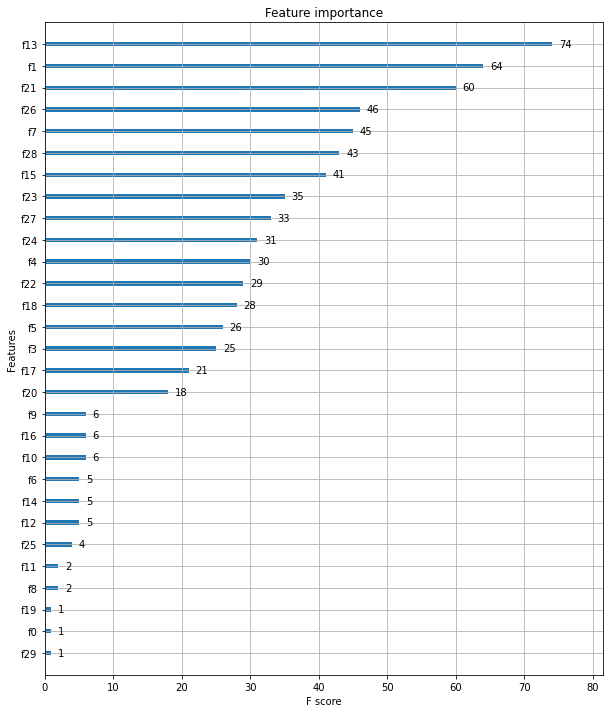

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12)) # 축 반환
plot_importance(xgb_model, ax=ax)

#### graphviz로 시각화

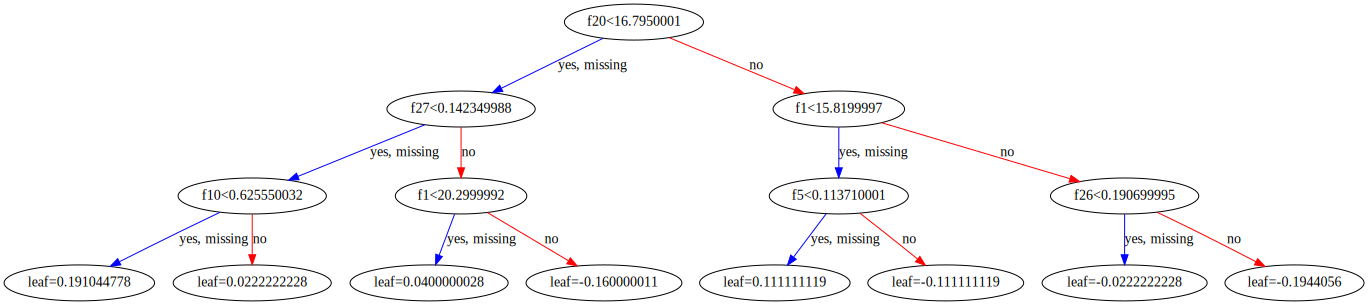

In [15]:
from sklearn.tree import export_graphviz
xgboost.to_graphviz(xgb_model, size='8,8')

### 교차 검증 수행
`xgb.cv()`
- params(dict) : 부스트 파라미터
- dtrain(DMatrix) : 학습 데이터
- num_boost_round(int)
- nfold(int) : CV폴드 개수
- stratified(bool)
- metrics(string or list of string) : 성능 평가 지표
- early_stopping_rounds(int)
- 반환값 : 데이터프레임

## 2. 사이킷런 Wrapper XGBoost

In [16]:
from xgboost import XGBClassifier

evals = [(X_test, y_test)]

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)

xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=400,
               eval_set=evals, eval_metric="logloss", verbose=True)

w_preds = xgb_wrapper.predict(X_test)
w_preds_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08619
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08644
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [17]:
get_clf_eval(y_test, w_preds, w_preds_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC:0.9951


앞서 파이썬 래퍼 XGBoost와 같은 결과

#### early_stopping_rounds=100으로 변경

In [18]:
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100,
               eval_set=evals, eval_metric="logloss", verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_preds_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08619
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08644
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [19]:
get_clf_eval(y_test, ws100_preds, ws100_preds_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC:0.9954


거의 차이가 없다

#### early_stopping_rounds=10으로 변경

In [21]:
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10,
               eval_set=evals, eval_metric="logloss", verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_preds_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [22]:
get_clf_eval(y_test, ws10_preds, ws10_preds_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC:0.9947


100일 때보다 성능이 낮아짐

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

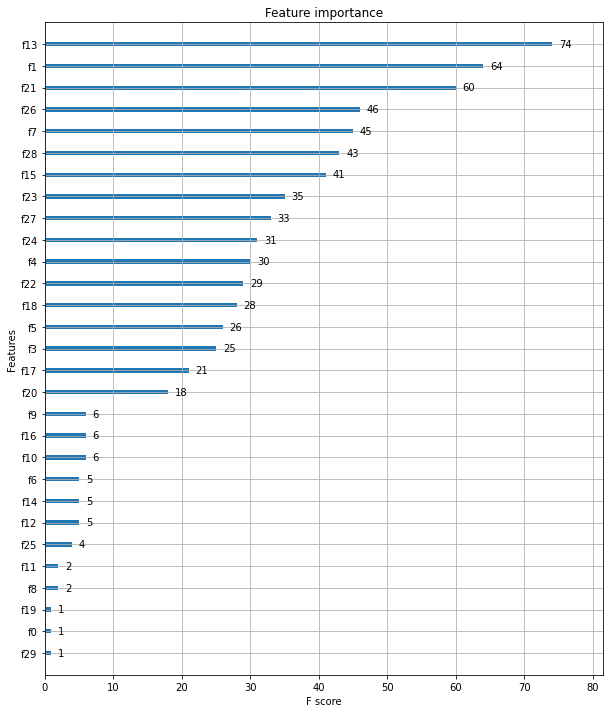

In [23]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)